# December, 20th 2020

**Motivation**: Simple dimensionality analysis using PCA in time dimension (not in neuron dimension).<br>
**Result**: Time evolution of traces is low dimensional.  With only 6 dimensions, we can explain around $80\%$ of the variance.  Furthermore, we can explain $90\%$ of the variance with 4 dimensions if we focus on stimulus presentation period only.  This does not necessarily mean that the dynamics is low dimensional.  We just show that typical shapes and trends that individual traces follow (in a bag of neuron setting) are low dimensional.

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

# load data
dirs_dict = get_dirs()
output_trial, output_freq = bag_of_neurons(dirs_dict['h_load_file'])

## PCA analysis

Here I take all responses and again put them in a bag of neurons.  Then fit a PCA transformation in the time dimension.  The reason behind this is I would like to know how diverse these traces are.  Do I need 5 dimensions to explain $80\%$ of the variance or do I need 50?

### PCA using full traces

Here the mapping is from 135-dimensional raw space into PC space.

In [ ]:
# HIDE CODE


# fit PCA
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

x_tst = output_trial['dff'][output_trial['tst_indxs']]
x_trn = output_trial['dff'][output_trial['trn_indxs']]

pca_results_full = pd.DataFrame()
for n_components in range(1, 31):
    pca = PCA(n_components=n_components).fit(x_trn)
    x_pred = pca.inverse_transform(pca.transform(x_tst))
    data_dict = {
        'n_components': [n_components, n_components],
        'metric': ['explained_variance', 'reconstruction_r2'],
        'value': [sum(pca.explained_variance_ratio_) * 100, r2_score(x_tst, x_pred) * 100],
    }
    pca_results_full = pd.concat([pca_results_full, pd.DataFrame.from_dict(data_dict)])

# plot
plt.figure(figsize=(9, 7))
sns.lineplot(data=pca_results_full, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=3, markersize=8)
plt.ylabel('%')
plt.xticks(range(1, 31))
plt.grid()
msg = '# PC componens vs. i) percent variance explained, and ii) reconstruction $R^2$ score on test data\n'
msg += 'we see that as few as $6$ dimensions are needed to explain '
msg += 'around $80\%$ of variance and above $70\%$ reconstruction'
plt.suptitle(msg, fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### PCA using stim presentation period only

Here I choose $t \in [30, 75)$ as period of interest. The mapping is from 45-dimensional raw space into PC space.  Therefore, just because of smaller initial space I expect more variance will be explained with fewer number of components relative to the full case.

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


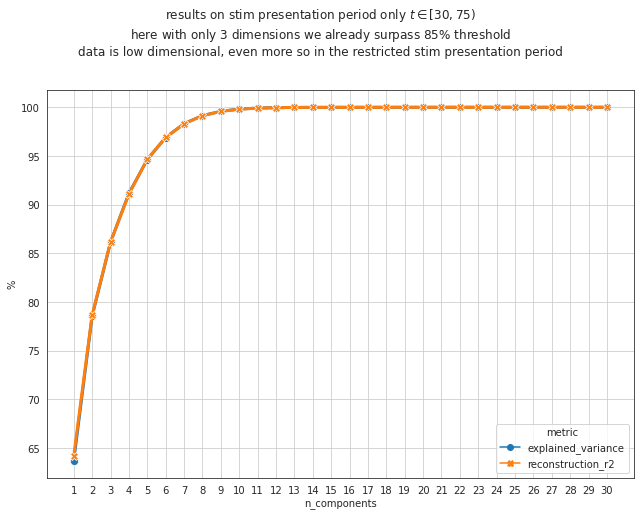

In [3]:
# HIDE CODE

trange = range(30, 75)

# fit PCA
pca_results = pd.DataFrame()

for n_components in tqdm(range(1, 31)):
    pca = PCA(n_components=n_components).fit(x_trn[:, trange])
    x_pred = pca.inverse_transform(pca.transform(x_tst[:, trange]))
    data_dict = {
        'n_components': [n_components, n_components],
        'metric': ['explained_variance', 'reconstruction_r2'],
        'value': [sum(pca.explained_variance_ratio_) * 100, r2_score(x_tst[:, trange], x_pred) * 100],
    }
    pca_results = pd.concat([pca_results, pd.DataFrame.from_dict(data_dict)])

# plot
plt.figure(figsize=(9, 7))
sns.lineplot(data=pca_results, x='n_components', y='value', hue='metric',
             style='metric', markers=True, dashes=False, lw=3, markersize=8)
plt.ylabel('%')
plt.xticks(range(1, 31))
plt.grid()
msg = 'results on stim presentation period only $t \in [30, 75)$\n'
msg += 'here with only $3$ dimensions we already surpass $85\%$ threshold\n'
msg += 'data is low dimensional, even more so in the restricted stim presentation period'
plt.suptitle(msg, fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### Visualizing PC dimensions

Here I plot the top 3 PC dimensions, for both full and limited case.  Also we see that PC dimensions learned using data from different trials don't look that different and they explain more or less the same amount of variance.

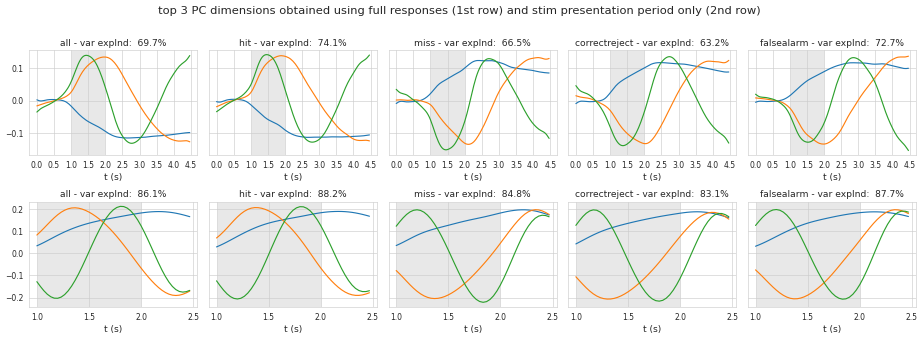

In [4]:
# HIDE CODE


# fit PCA
trials = ['all'] + output_trial['df'].trial.unique().tolist()
pca_dict = {}

for trial in tqdm(trials, leave=False):
    if trial == 'all':
        tst_indxs = output_trial['tst_indxs']
        trn_indxs = output_trial['trn_indxs']
    else:
        indxs = np.where(output_trial['df'].trial == trial)[0]
        tst_indxs = [i for i in output_trial['tst_indxs'] if i in indxs]
        trn_indxs = [i for i in output_trial['trn_indxs'] if i in indxs]
    x_tst = output_trial['dff'][tst_indxs]
    x_trn = output_trial['dff'][trn_indxs]

    pca_full = PCA().fit(x_trn)
    pca = PCA().fit(x_trn[:, trange])
    
    pca_dict.update({trial: (pca_full, pca)})

# plot
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 5, figsize=(17, 6), dpi=55, sharey='row')

for j, trial in enumerate(pca_dict.keys()):
    pca_full, pca = pca_dict[trial]
    
    axes[0, j].plot(range(135), pca_full.components_[:3].T)
    axes[1, j].plot(trange, pca.components_[:3].T)
    msg = '{:s} - var explnd:  {:.1f}{:s}'
    axes[0, j].set_title(msg.format(trial, sum(pca_full.explained_variance_ratio_[:3]) * 100, '%'))
    axes[1, j].set_title(msg.format(trial, sum(pca.explained_variance_ratio_[:3]) * 100, '%'))

    for i in range(2):
        axes[i, j].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
        xticks = range(0, 135 + 1, 15) if i == 0 else range(trange.start, trange.stop + 1, 15)
        axes[i, j].set_xticks(xticks)
        axes[i, j].set_xticklabels([t / 30 for t in xticks])
        axes[i, j].set_xlabel('t (s)', fontsize=12)

msg ='top 3 PC dimensions obtained using full responses (1st row) and stim presentation period only (2nd row)'
fig.suptitle(msg, fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

## Discussion
### temporal profile of individual traces is low dimensional

This analysis is not really informative, but wanted to quickly do it and keep it here for the record.  The real question is dimensionality reduction in neuron space.  How can we take a trial with $nc$ neurons and project it down to a low dimensional space, while maintaining predictive power about trial labels?  This will be the subject of following sections.